In [1]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## <span id="1"></span> ** 1. Importing Libraries and Reading the Dataset **

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import gc, datetime, random
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = 4000

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [3]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

y = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
train = train.drop('isFraud', axis=1)

Train shape:  (590540, 433)
Test shape:  (506691, 432)
CPU times: user 42.8 s, sys: 6.09 s, total: 48.9 s
Wall time: 49.1 s


In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 1970.87 MB
Memory usage after optimization is: 547.26 MB
Decreased by 72.2%
Memory usage of dataframe is 1693.87 MB
Memory usage after optimization is: 480.15 MB
Decreased by 71.7%


## <span id="2"></span> ** 2. Feature Engineering **

### <span id="3"></span> ** Add New Features **

In [5]:
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)

    data['D9'] = np.where(data['D9'].isna(),0,1)
    
    return data

train = addNewFeatures(train)
test = addNewFeatures(test)

In [6]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [7]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [8]:
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,4.242188,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,147.625,255.25,185.250,999.000,258.0000,210.7500,258.0000,210.7500,193.0000,176.1250
2987001,86401,3.400391,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,147.625,255.25,212.750,999.000,213.6250,999.0000,213.6250,999.0000,240.0000,999.0000
2987002,86469,4.093750,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,147.625,255.25,98.750,141.125,104.8125,130.3750,104.8125,130.3750,65.6875,55.1875
2987003,86499,3.931641,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,147.625,255.25,124.375,191.875,120.9375,196.7500,120.9375,196.7500,113.0625,211.7500
2987004,86506,3.931641,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,147.625,255.25,212.750,999.000,99.8125,69.8125,99.8125,69.8125,50.0000,NaN


### <span id="4"></span> ** Handle Email Domains **

In [9]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### <span id="5"></span> ** Handle P Email Domain and R Email Domain **

In [11]:
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train=setDomain(train)
test=setDomain(test)

### <span id="6"></span> ** Set Time **

In [12]:
def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    return df
    
train=setTime(train)
test=setTime(test)

### <span id="7"></span> ** Handle Browser Version **

In [13]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

### <span id="8"></span> ** Handle Device Type **

In [14]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    #df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

### <span id="9"></span> ** Set Frequency **

In [15]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

## <span id="10"></span> ** 3. Data Preprocessing **

In [16]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    #cols_to_drop.remove('isFraud')
    return cols_to_drop

In [17]:
cols_to_drop = get_useless_columns(train)

More than 90% null: 12
More than 90% repeated value: 71


In [18]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [19]:
print(train.shape)
print(test.shape)
print(y.shape)

(590540, 440)
(506691, 440)
(590540,)


In [20]:
numerical_cols = train.select_dtypes(exclude = 'object').columns
categorical_cols = train.select_dtypes(include = 'object').columns

In [21]:
categorical_cols[:5]

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain'], dtype='object')

In [22]:
# Label Encoding
for f in train.columns:
    if train[f].dtype.name =='object' or test[f].dtype.name =='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [23]:
train = train.fillna(-999)
test = test.fillna(-999)

In [24]:
print(train.isnull().sum().max())
print(test.isnull().sum().max())

0
0


In [25]:
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,DT_M_total,DT_W_total,DT_D_total,uid_DT_M,uid_DT_W,uid_DT_D
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,4.242188,4,13926,-999.0,150.0,1,142.0,1,315.0,...,953271,6,6,2,137321,12093,5122,0.000015,0.000083,0.000195
2987001,86401,3.400391,4,2755,404.0,150.0,2,102.0,1,325.0,...,953271,1328,1328,105,137321,12093,5122,0.001216,0.001075,0.001367
2987002,86469,4.093750,4,4663,490.0,150.0,4,166.0,2,330.0,...,953271,1787,1787,46,137321,12093,5122,0.001347,0.002150,0.001952
2987003,86499,3.931641,4,18132,567.0,150.0,2,117.0,2,476.0,...,953271,7602,7602,362,137321,12093,5122,0.006015,0.009179,0.009567
2987004,86506,3.931641,1,4497,514.0,150.0,2,102.0,1,420.0,...,1430,30,30,1,137321,12093,5122,0.000015,0.000083,0.000195


In [26]:
X = train.drop(['TransactionDT', 'DT'], axis=1)
X_test = test.drop(['TransactionDT', 'DT'], axis=1)

In [27]:
print("X:", X.shape)
print("y_train:", y.shape)
print("X_test:", X_test.shape)

X: (590540, 438)
y_train: (590540,)
X_test: (506691, 438)


## <span id="11"></span> ** 4. Model **

### <span id="12"></span> ** LightGBM **

In [29]:
params = {'num_leaves': 546,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.2181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3299927210061127,
          'reg_lambda': 0.3885237330340494,
          'random_state': 42,
}

In [30]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.970647	valid_1's auc: 0.897644
[400]	training's auc: 0.989837	valid_1's auc: 0.910956
[600]	training's auc: 0.996696	valid_1's auc: 0.919003
[800]	training's auc: 0.998963	valid_1's auc: 0.922943
[1000]	training's auc: 0.999694	valid_1's auc: 0.924848
[1200]	training's auc: 0.999916	valid_1's auc: 0.92583
[1400]	training's auc: 0.99998	valid_1's auc: 0.926765
[1600]	training's auc: 0.999996	valid_1's auc: 0.927194
[1800]	training's auc: 0.999999	valid_1's auc: 0.927579
[2000]	training's auc: 1	valid_1's auc: 0.927714
[2200]	training's auc: 1	valid_1's auc: 0.927762
[2400]	training's auc: 1	valid_1's auc: 0.927565
[2600]	training's auc: 1	valid_1's auc: 0.927561
Early stopping, best iteration is:
[2193]	training's auc: 1	valid_1's auc: 0.927795
Fold 1 | AUC: 0.9277946421742906
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.970161	valid_1's auc: 0.92248
[400]	tra

## <span id="13"></span> ** 5. Submission **

In [31]:
submission = pd.read_csv('../input/sample_submission.csv')

In [32]:
submission['isFraud'] = y_preds

In [33]:
submission.head()

,TransactionID,isFraud
0,3663549,0.000190
1,3663550,0.000562
2,3663551,0.000772
3,3663552,0.000598
4,3663553,0.000337


In [34]:
submission.to_csv('../predictions/pred17.csv', index=False)

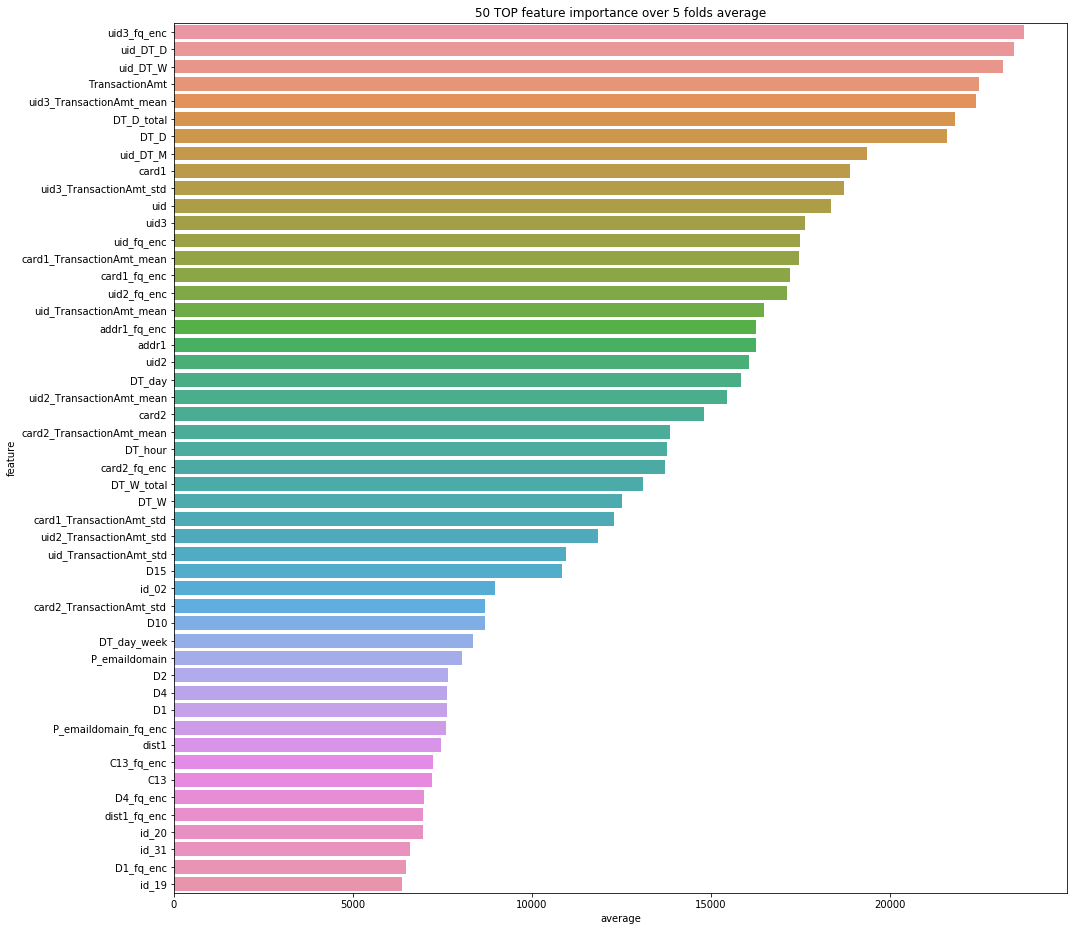

In [35]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('../importances/importances17.csv',index=False)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [36]:
!kaggle competitions submit -c ieee-fraud-detection -f ../predictions/pred17.csv -m "pred17"

100%|███████████████████████████████████████| 14.3M/14.3M [00:34<00:00, 431kB/s]
Successfully submitted to IEEE-CIS Fraud Detection